In this notebook we'll explain in detail the modeling decisions made in order to answer the proposed question

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

import statsmodels.api as sm
import itertools

# 1. Data Preprocessing

In [2]:
df=pd.read_csv('train.csv')

In [3]:
df.head()

,Unnamed: 0,y
0,01.01.15,1.91157
1,01.02.15,1.44733
2,01.03.15,1.89355
3,01.04.15,2.03274
4,01.05.15,2.27843


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  74 non-null     object 
 1   y           74 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.5+ KB


We'll give columns an appropriate name, drop empty registers and change date format to datetime

In [5]:
df.rename(columns = {'Unnamed: 0':'date'}, inplace = True)
df.dropna( inplace=True)
df['date'] = pd.to_datetime(df["date"],dayfirst=True)

/tmp/ipykernel_23322/3037401195.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df["date"],dayfirst=True)


In [6]:
df.head()

,date,y
0,2015-01-01,1.91157
1,2015-02-01,1.44733
2,2015-03-01,1.89355
3,2015-04-01,2.03274
4,2015-05-01,2.27843


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74 entries, 0 to 73
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    74 non-null     datetime64[ns]
 1   y       74 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


Check for Outliers

In [8]:
df.describe()

,date,y
count,74,74.000000
mean,2018-01-15 10:03:14.594594560,2.474047
min,2015-01-01 00:00:00,1.447330
25%,2016-07-08 18:00:00,1.980592
50%,2018-01-16 12:00:00,2.444870
75%,2019-07-24 06:00:00,2.919247
max,2021-02-01 00:00:00,3.791290
std,NaN,0.593002


Change series format into time-series

In [9]:
df = df.set_index('date')
df=df.asfreq(freq='MS')
df.head()

,y
date,
2015-01-01,1.91157
2015-02-01,1.44733
2015-03-01,1.89355
2015-04-01,2.03274
2015-05-01,2.27843


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74 entries, 2015-01-01 to 2021-02-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       74 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


## 1.1. Train-test split

This step is neccesary for modelling validation purposes. However, in time-series analysis it's not a good practice to randomly split our sample, since time-series are dependent on the ordering. Therefore, we should select a date that will serve as our threshold between training and testing (validation) sample.

In [11]:
#We take last 20 dates as test sample (between 20% and 30% of sample size)
df_train=df[:-20]
df_test=df[-20:]

Text(0.5, 1.0, 'Train-test split')

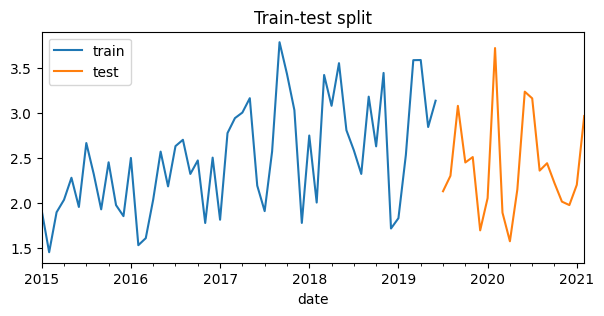

In [12]:
#Plotting the split
fig, ax=plt.subplots(figsize=(7, 3))
df_train['y'].plot(ax=ax, label='train')
df_test['y'].plot(ax=ax, label='test')
ax.legend()
ax.set_title('Train-test split')

In [13]:
len(df_train)+len(df_test)

74

# 2. EDA

Linear regressors are very common at time-series forecasting, since they excel at extrapolating trends. Thus, we will use an ARIMA-type regressor to account for the auto-regressive component as well (time-series tend to be dependent on its previous values). 

In order to apply this model, we will use EDA to get an idea of the range in which we can find its optimal parameters.

We will call (p,d,q) ARIMA's usual parameters.

## 2.1.Stationary behaviour

We'll begin by checking stationary behaviour, a requisite whe applying an ARIMA-type model

In [14]:
# Stationary Test (Dickey-Fuller and KPSS)
# ==============================================================================
warnings.filterwarnings("ignore")

# We test the original series together with 3 next diffs
df_diff_1 = df_train.diff().dropna()
df_diff_2 = df_diff_1.diff().dropna()
df_diff_3 = df_diff_2.diff().dropna()
df_diff_4 = df_diff_3.diff().dropna()

print('Stationary Test original series')
print('-------------------------------------')
adfuller_result = adfuller(df_train)
kpss_result = kpss(df_train)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nStationary Test diff series (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_diff_1)
kpss_result = kpss(df_diff_1)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nStationary Test diff series (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_diff_2)
kpss_result = kpss(df_diff_2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nStationary Test diff series (order=3)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_diff_3)
kpss_result = kpss(df_diff_3)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nStationary Test diff series (order=4)')
print('--------------------------------------------------')
adfuller_result = adfuller(df_diff_4)
kpss_result = kpss(df_diff_4)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

Stationary Test original series
-------------------------------------
ADF Statistic: -1.8485226929121295, p-value: 0.35665125605248565
KPSS Statistic: 0.9420010419765072, p-value: 0.01

Stationary Test diff series (order=1)
--------------------------------------------------
ADF Statistic: -6.2954135730597, p-value: 3.5157526285570704e-08
KPSS Statistic: 0.03345849314577245, p-value: 0.1

Stationary Test diff series (order=2)
--------------------------------------------------
ADF Statistic: -4.374536296720159, p-value: 0.0003291953438289531
KPSS Statistic: 0.02402610890573997, p-value: 0.1

Stationary Test diff series (order=3)
--------------------------------------------------
ADF Statistic: -5.054974102912251, p-value: 1.7255856868516354e-05
KPSS Statistic: 0.07115337671449343, p-value: 0.1

Stationary Test diff series (order=4)
--------------------------------------------------
ADF Statistic: -6.63232368552372, p-value: 5.674124086979528e-09
KPSS Statistic: 0.09001395289417197, p-val

- Null hypothesis for Dickey-Fuller test is that the series is not stationary.
- Null hypothesis for KPSS test is that the series is  stationary.

Upon inspection of tests results, we see that we should differentiate the original series once. Therefore, we would start with a value of d=1 for this ARIMA parameter.

## 2.2.Autocorrelation

In order to get an idea of the order of the other 2 parameters, we will use autocorrelation plots. Since we have chosen to differantiate the series once, we will apply the autocorrelation plots to the diff series of 1st order.

Text(0.5, 1.0, 'Autocorrelation plot for diff series (order=1)')

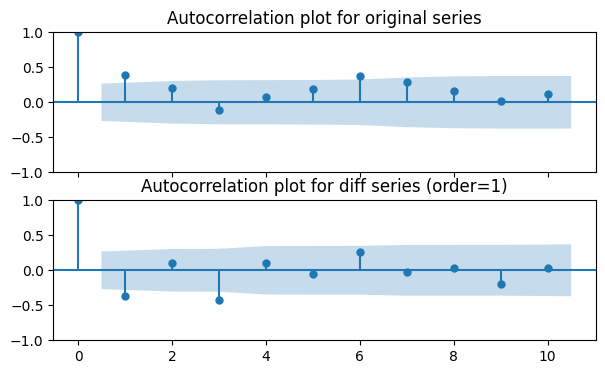

In [15]:
#  Autocorrelation plot for original and diff series (order 1)
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df_train, ax=axs[0], lags=10, alpha=0.05)
axs[0].set_title('Autocorrelation plot for original series')
plot_acf(df_diff_1, ax=axs[1], lags=10, alpha=0.05)
axs[1].set_title('Autocorrelation plot for diff series (order=1)')

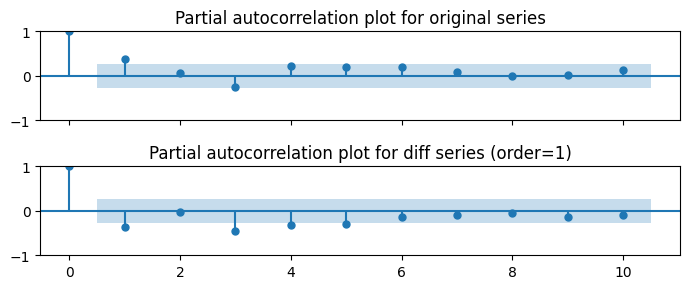

In [16]:
# Partial autocorrelation plot for original and diff series (order 1)
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df_train, ax=axs[0], lags=10, alpha=0.05)
axs[0].set_title('Partial autocorrelation plot for original series')
plot_pacf(df_diff_1, ax=axs[1], lags=10, alpha=0.05)
axs[1].set_title('Partial autocorrelation plot for diff series (order=1)')
plt.tight_layout()

- Autocorrelation plot suggests the folowing values for parameter q=1,2
- Partial autocorrelation plot suggests the folowing values for parameter p=1,3,4,5

## 2.3.Series decomposition

Next, we will have a look at the series decomposition to examine trend and seasonality components

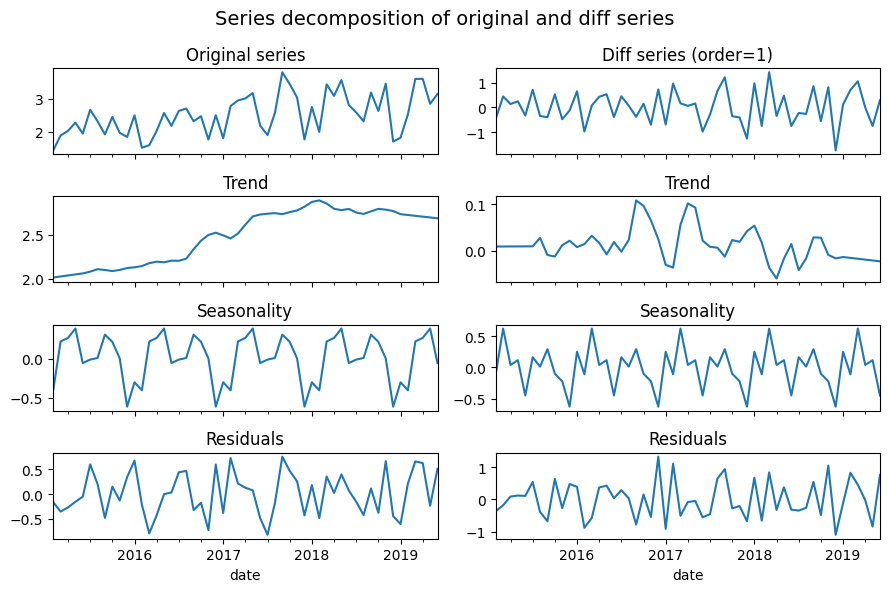

In [17]:
# Series decomposition of original and diff series
# ==============================================================================
res_decompose = seasonal_decompose(df_train, model='additive', extrapolate_trend='freq')
res_descompose_diff_2 = seasonal_decompose(df_diff_1, model='additive', extrapolate_trend='freq')

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Original series')
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Trend')
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Seasonality')
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuals')
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Diff series (order=1)')
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Trend')
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Seasonality')
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuals')
fig.suptitle('Series decomposition of original and diff series', fontsize=14)
fig.tight_layout()

We can infer from the above plots that the series seems to have a seasonal component with a period of 12 months. Therefore, we will use a SARIMAX model to account for seasonality as well.

We doublecheck stationarity after diff and removing seasonality effect.

In [18]:
# 1st order diff combined with seasonality diff
# ==============================================================================
datos_diff_1_12 = df_train.diff().diff(12).dropna()

warnings.filterwarnings("ignore")
adfuller_result = adfuller(datos_diff_1_12)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

ADF Statistic: -5.321662384928604, p-value: 4.937368442610389e-06
KPSS Statistic: 0.0318320231640735, p-value: 0.1


# 3.Modelling

Thanks to EAD, we have an intuition about the range in which we can find optimal hyperparameters.

We first tune a SARIMAX model to find the best-performant one.

## 3.1. Define Grid from EDA results

In [13]:
p = [1,3] 
d=[1,2] 
q=range(0,3) 
pdq = list(itertools.product(p,d, q)) #all combinations for pdq
pdq = list(dict.fromkeys(pdq)) #drop duplicates
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d, q))]
seasonal_pdq = list(dict.fromkeys(seasonal_pdq)) #drop duplicates

## 3.2.Picking best-performing model over validation (test) set

In [14]:
warnings.filterwarnings("ignore")
rmse_list=[]

# loop through all parameter combinations and store results
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try: 
            modelo = SARIMAX(endog = df_train, order = param,seasonal_order = param_seasonal)
            modelo_res = modelo.fit(disp=0)
            predicciones_statsmodels = modelo_res.get_forecast(steps=len(df_test)).predicted_mean
            rmse = np.sqrt(np.square(np.subtract(predicciones_statsmodels,df_test['y'])).mean())
            rmse_list.append(rmse)
        #There might be parameter combinations that bring errors, thus we indicate the loop to ignore those cases
        except: 
            continue

# keep parameter combination that brings the lowest error
min_pos=np.array(rmse_list).argmin()
index_pdq=int(min_pos/len(seasonal_pdq))
index_season=min_pos%len(seasonal_pdq)
param_1=pdq[index_pdq]
param_2=seasonal_pdq[index_season]

warnings.filterwarnings("default")

In [15]:
param_1

(1, 1, 0)

In [16]:
param_2

(3, 1, 2, 12)

## 3.3. Evaluating model-performance

In [17]:
# best-performant model
modelo=SARIMAX(endog = df_train, order = param_1,seasonal_order = param_2)
modelo_res = modelo.fit(disp=0)

# evaluate model over validation set 
predicciones_statsmodels = modelo_res.get_forecast(steps=len(df_test)).predicted_mean

/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# Calculate the root mean squared error of best-performant model
rmse = np.sqrt(np.square(np.subtract(predicciones_statsmodels,df_test['y'])).mean())
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 0.6970877123694457


In [19]:
# mean value on test (validation) set
df_test.mean()

y    2.405844
dtype: float64

We get an average error of 28.97% (approx. 30%) in our validation set, which is yet quite big. In section 5 we see some possible ways to improve performance.

# 4. Forecasting

In [20]:
# evaluate model over validation set + 12 next steps
predicciones_statsmodels = modelo_res.get_forecast(steps=len(df_test)+12).predicted_mean
predicciones_statsmodels.name = 'y'

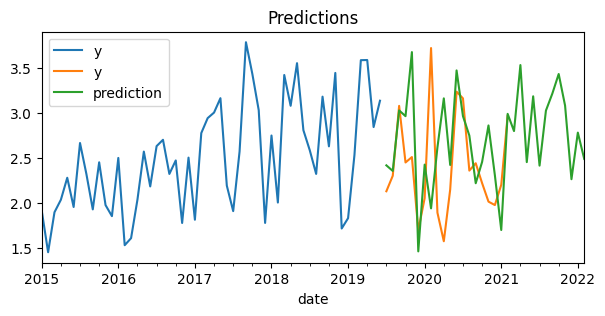

In [21]:
# Plot predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
df_train.plot(ax=ax, label='train')
df_test.plot(ax=ax, label='test')
predicciones_statsmodels.plot(ax=ax, label='prediction')
ax.set_title('Predictions')
ax.legend()

## 4.1.Generate sample for next 12 steps

In [22]:
# Prepare sample with prediction for 12 next steps
predictions=predicciones_statsmodels[-12:]
predictions_df=pd.DataFrame(predictions)
predictions_df['date']=predictions_df.index
predictions_df=predictions_df.reset_index(drop=True)
predictions_df=predictions_df[['date','y']]
predictions_df['date']=predictions_df['date'].dt.strftime('%d.%m.%y')

In [23]:
# save sample
predictions_df.to_csv('test_set.csv',index=False)

# 5. Further Improvements

- Sample size is not very big in this case (74 obs), therefore simple train-test split might not be the best option here, since data in the subsamples might not be representative of the problem. A good alternative would be to perform multiple train-test splits. However, this would increase computational cost.

- Althought linear models are good at forecasting trends, they tend to fail at learning interactions between predictors. Thus, combining our regressor with some kind of tree-based algorithm would probably improve performance.

- Of course, a more exhaustive hyperparameters search alwasys yields a better performance, so the hyperparams. space could be enhanced, incrementing computational cost as well.